#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from time import process_time

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


<h2><mark><b>Answer <h2><mark><b>

#####For a classification problem, depending on the output type, there are several options for output activation. Two popular ones are sigmoid and softmax. Between these two options, since the output is binary, the sigmoid function is a good option for the activation function of the output layer. This way of reasoning also works for choosing the loss function. Since the output is binary in this classification problem, binary cross-entropy is a good choice. In fact, the binary cross-entropy will calculate the cross-entropy loss between the predicted classes and the true classes.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(tf.keras.layers.SimpleRNN(units=32, activation='tanh', name='Hidden-Recurrent-Layer')) 
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output-Layer'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 Hidden-Recurrent-Layer (Sim  (None, 32)               1376      
 pleRNN)                                                         
                                                                 
 Output-Layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [ ]:
t_start = process_time() 

history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
t_stop = process_time()
time_RNN = t_stop - t_start

print("RNN")
print("CPU time:", time_RNN)

Epoch 1/10
196/196 [==============================] - 20s 99ms/step - loss: 0.6890 - accuracy: 0.5420 - val_loss: 0.6817 - val_accuracy: 0.5386
Epoch 2/10
196/196 [==============================] - 20s 100ms/step - loss: 0.5610 - accuracy: 0.7301 - val_loss: 0.4433 - val_accuracy: 0.8017
Epoch 3/10
196/196 [==============================] - 19s 96ms/step - loss: 0.3986 - accuracy: 0.8213 - val_loss: 0.5442 - val_accuracy: 0.7200
Epoch 4/10
196/196 [==============================] - 19s 96ms/step - loss: 0.2941 - accuracy: 0.8789 - val_loss: 0.4177 - val_accuracy: 0.8282
Epoch 5/10
196/196 [==============================] - 19s 95ms/step - loss: 0.1962 - accuracy: 0.9269 - val_loss: 0.4679 - val_accuracy: 0.8000
Epoch 6/10
196/196 [==============================] - 19s 97ms/step - loss: 0.1274 - accuracy: 0.9568 - val_loss: 0.4712 - val_accuracy: 0.8261
Epoch 7/10
196/196 [==============================] - 19s 96ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.5543 - val_accuracy

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 10s - loss: 0.6612 - accuracy: 0.8271 - 10s/epoch - 25ms/step
accuracy: 82.71%


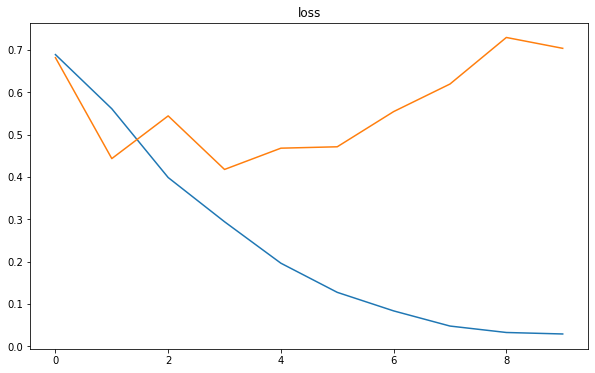

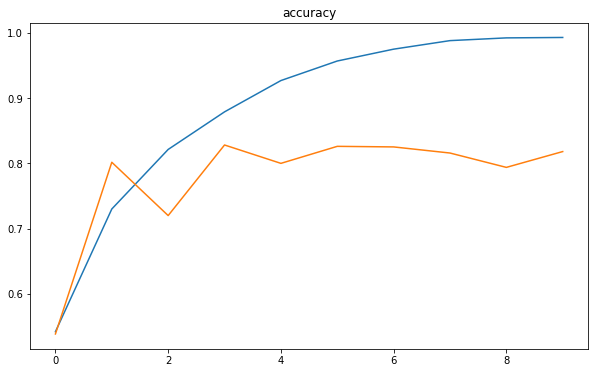

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.

modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
modelLSTM.add(tf.keras.layers.LSTM(units=14, activation='tanh', name='Hidden-Recurrent-Layer')) 
modelLSTM.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output-Layer'))
modelLSTM.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
modelLSTM.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          100000    
                                                                 
 Hidden-Recurrent-Layer (LST  (None, 14)               1400      
 M)                                                              
                                                                 
 Output-Layer (Dense)        (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t_start = process_time() 
history = modelLSTM.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
t_stop = process_time()
time_LSTM = t_stop - t_start

print("LSTM")
print("CPU time:", time_LSTM)

Epoch 1/10
196/196 [==============================] - 38s 188ms/step - loss: 0.5115 - accuracy: 0.7549 - val_loss: 0.3431 - val_accuracy: 0.8624
Epoch 2/10
196/196 [==============================] - 36s 186ms/step - loss: 0.2717 - accuracy: 0.8971 - val_loss: 0.3019 - val_accuracy: 0.8776
Epoch 3/10
196/196 [==============================] - 37s 190ms/step - loss: 0.2040 - accuracy: 0.9310 - val_loss: 0.3062 - val_accuracy: 0.8773
Epoch 4/10
196/196 [==============================] - 37s 189ms/step - loss: 0.1666 - accuracy: 0.9456 - val_loss: 0.3237 - val_accuracy: 0.8734
Epoch 5/10
196/196 [==============================] - 36s 185ms/step - loss: 0.1534 - accuracy: 0.9494 - val_loss: 0.3522 - val_accuracy: 0.8663
Epoch 6/10
196/196 [==============================] - 36s 184ms/step - loss: 0.1209 - accuracy: 0.9636 - val_loss: 0.3678 - val_accuracy: 0.8654
Epoch 7/10
196/196 [==============================] - 36s 183ms/step - loss: 0.1034 - accuracy: 0.9699 - val_loss: 0.3922 - val_ac

391/391 - 9s - loss: 0.4285 - accuracy: 0.8624 - 9s/epoch - 24ms/step
accuracy: 86.24%


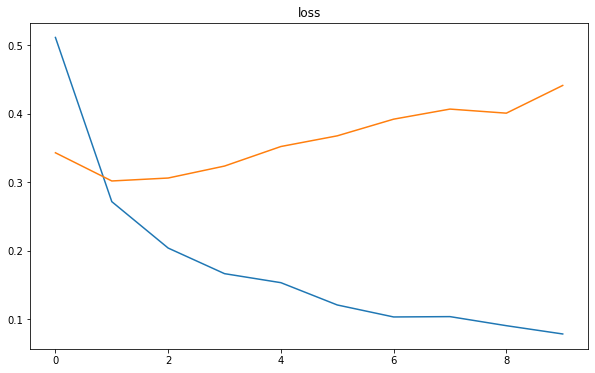

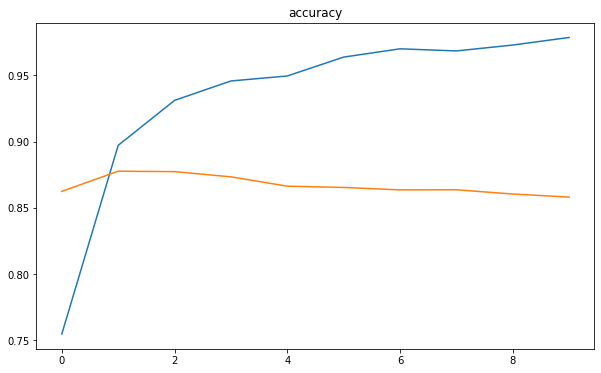

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = modelLSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (modelLSTM.metrics_names[1], scores[1]*100))

In [ ]:
# GRU - complete with model definition, summary, fit and plots.
 

modelGRU = keras.models.Sequential()
modelGRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
modelGRU.add(tf.keras.layers.GRU(units=16, activation='tanh', name='Hidden-Recurrent-Layer')) 
modelGRU.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output-Layer'))
modelGRU.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
modelGRU.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 Hidden-Recurrent-Layer (GRU  (None, 16)               1344      
 )                                                               
                                                                 
 Output-Layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t_start = process_time()
history = modelGRU.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
t_stop = process_time()
time_GRU = t_stop - t_start

print("GRU")
print("CPU time:", time_GRU)

Epoch 1/10
196/196 [==============================] - 38s 184ms/step - loss: 0.6177 - accuracy: 0.6461 - val_loss: 0.4372 - val_accuracy: 0.7987
Epoch 2/10
196/196 [==============================] - 36s 182ms/step - loss: 0.3315 - accuracy: 0.8590 - val_loss: 0.3375 - val_accuracy: 0.8588
Epoch 3/10
196/196 [==============================] - 35s 180ms/step - loss: 0.2320 - accuracy: 0.9108 - val_loss: 0.3255 - val_accuracy: 0.8643
Epoch 4/10
196/196 [==============================] - 35s 180ms/step - loss: 0.1859 - accuracy: 0.9331 - val_loss: 0.3334 - val_accuracy: 0.8642
Epoch 5/10
196/196 [==============================] - 35s 180ms/step - loss: 0.1574 - accuracy: 0.9462 - val_loss: 0.3731 - val_accuracy: 0.8641
Epoch 6/10
196/196 [==============================] - 35s 179ms/step - loss: 0.1406 - accuracy: 0.9523 - val_loss: 0.3811 - val_accuracy: 0.8611
Epoch 7/10
196/196 [==============================] - 35s 179ms/step - loss: 0.1221 - accuracy: 0.9595 - val_loss: 0.4039 - val_ac

391/391 - 7s - loss: 0.4957 - accuracy: 0.8514 - 7s/epoch - 19ms/step
accuracy: 85.14%


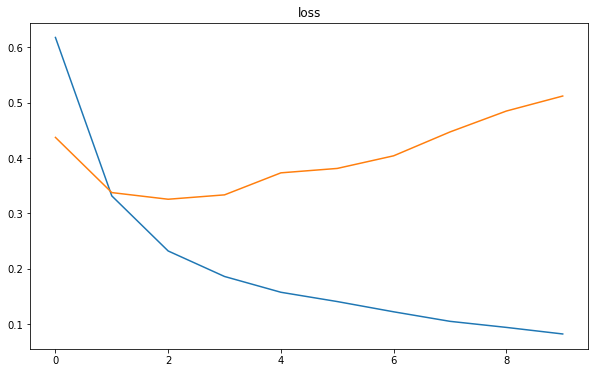

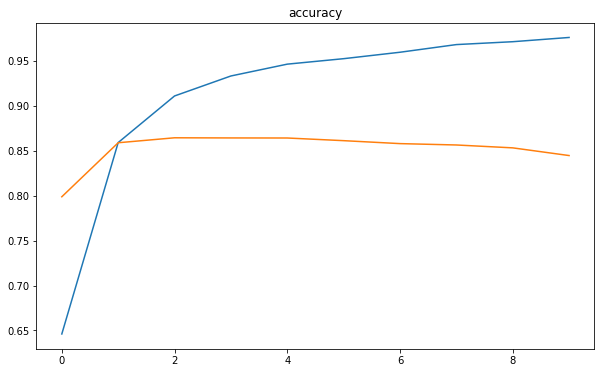

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = modelGRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (modelGRU.metrics_names[1], scores[1]*100))

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 



<!DOCTYPE html>
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
}
</style>
</head>
<body>

<h2><mark><b>Answer<h2><mark><b>

<p>To have the same number of parameters we should consider that:</p>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Number of Units</th>
    <th>Number of parameters in hidden layer</th>
    <th>CPU time(s)</th>
    <th>Test Accuracy</th>

  </tr>
  <tr>
    <th>Simple RNN</th>
    <td>32</td>
    <td>1376</td>
    <td>342.43</td>
    <td>82.71%</td>

  </tr>
  <tr>
    <th>LSTM</th>
    <td>14</td>
    <td>1400</td>
    <td>625.01</td>
    <td>86.24%</td>

  </tr>
  <tr>
    <th>GRU</th>
    <td>16</td>
    <td>1344</td>
    <td>634.72</td>
    <td>85.14%</td>

  </tr>

</table>

</body>
</html>

#####As mentioned above, to have a meaningful comparison among models, it needs to have the same number of parameters. By different traying numbers of units, we Roughly achieved the same number of parameters for different models. The results show that the LSTM and GRU have better accuracy than simple RNN, but they need more time to reach this level of accuracy than simple RNN. Also, between LSTM and GRU, the LSTM model has better accuracy with the same running time.


### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t_start = process_time()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
t_stop = process_time()
time_Bidirectional_LSTM = t_stop - t_start

print("Bidirectional LSTM")
print("CPU time:", time_Bidirectional_LSTM)

Epoch 1/5
196/196 [==============================] - 123s 606ms/step - loss: 0.6575 - accuracy: 0.6160 - val_loss: 0.5498 - val_accuracy: 0.7019
Epoch 2/5
196/196 [==============================] - 116s 590ms/step - loss: 0.3740 - accuracy: 0.8447 - val_loss: 0.3515 - val_accuracy: 0.8539
Epoch 3/5
196/196 [==============================] - 116s 591ms/step - loss: 0.2399 - accuracy: 0.9086 - val_loss: 0.3077 - val_accuracy: 0.8752
Epoch 4/5
196/196 [==============================] - 116s 594ms/step - loss: 0.1889 - accuracy: 0.9317 - val_loss: 0.3101 - val_accuracy: 0.8680
Epoch 5/5
196/196 [==============================] - 116s 592ms/step - loss: 0.1533 - accuracy: 0.9467 - val_loss: 0.3228 - val_accuracy: 0.8705
Bidirectional LSTM
CPU time: 1110.0289968360003


391/391 - 21s - loss: 0.3099 - accuracy: 0.8767 - 21s/epoch - 54ms/step
accuracy: 87.67%


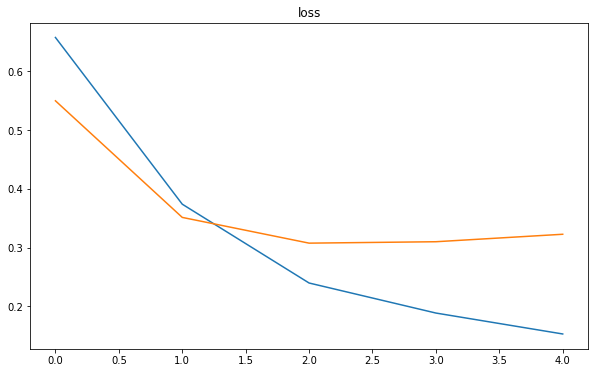

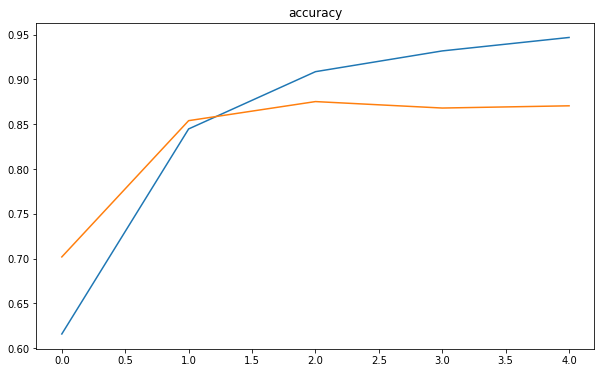

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

<!DOCTYPE html>
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
}
</style>
</head>
<body>

<h2><mark><b>Experiments<h2><mark><b>

<p>The different experiments has been listed below:</p>

<table style="width:100%">
  <tr>
    <th>Number</th>
    <th>Embedding size</th>
    <th>Number of attention heads</th>
    <th>Hidden layer size</th>
    <th>Number of Parameters</th>
    <th>Test Accuracy</th>

  </tr>
  <tr>
    <th>1</th>
    <td>3</td>
    <td>1</td>
    <td>16</td>
    <td>30876</td>
    <td>86.64%</td>

  </tr>
  <tr>
    <th>2</th>
    <td>3</td>
    <td>1</td>
    <td>64</td>
    <td>31212</td>
    <td>86.30%</td>

  </tr>
  <tr>
    <th>3</th>
    <td>3</td>
    <td>4</td>
    <td>16</td>
    <td>31011</td>
    <td>86.50%</td>

  </tr>
  <tr>
    <th>4</th>
    <td>3</td>
    <td>4</td>
    <td>64</td>
    <td>31347</td>
    <td>86.94%</td>

  </tr>
  <tr>
    <th>5</th>
    <td>9</td>
    <td>1</td>
    <td>16</td>
    <td>92730</td>
    <td>85.54%</td>

  </tr>
  <tr>
    <th>6</th>
    <td>9</td>
    <td>1</td>
    <td>64</td>
    <td>93642</td>
    <td>86.02%</td>

  </tr>
  <tr>
    <th>7</th>
    <td>9</td>
    <td>4</td>
    <td>16</td>
    <td>93783</td>
    <td>85.74%</td>

  </tr>
  <tr>
    <th>8</th>
    <td>9</td>
    <td>4</td>
    <td>64</td>
    <td>94695</td>
    <td>86.14%</td>




</table>

</body>
</html>



In [ ]:
embed_dim = 9  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model9464 = keras.Model(inputs=inputs, outputs=outputs)
model9464.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model9464.summary()


Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 9)           91800     
 g_33 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_33 (Trans  (None, 200, 9)           2674      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_33  (None, 9)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_134 (Dropout)       (None, 9)                 0  

In [ ]:
history = model9464.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

Epoch 1/5
196/196 [==============================] - 5s 21ms/step - loss: 0.4752 - accuracy: 0.7628 - val_loss: 0.3515 - val_accuracy: 0.8465
Epoch 2/5
196/196 [==============================] - 4s 19ms/step - loss: 0.2508 - accuracy: 0.9036 - val_loss: 0.3408 - val_accuracy: 0.8522
Epoch 3/5
196/196 [==============================] - 4s 21ms/step - loss: 0.1952 - accuracy: 0.9292 - val_loss: 0.3401 - val_accuracy: 0.8647
Epoch 4/5
196/196 [==============================] - 5s 23ms/step - loss: 0.1601 - accuracy: 0.9455 - val_loss: 0.3568 - val_accuracy: 0.8622
Epoch 5/5
196/196 [==============================] - 5s 23ms/step - loss: 0.1429 - accuracy: 0.9502 - val_loss: 0.3962 - val_accuracy: 0.8625


391/391 - 2s - loss: 0.3887 - accuracy: 0.8614 - 2s/epoch - 4ms/step
accuracy: 86.14%


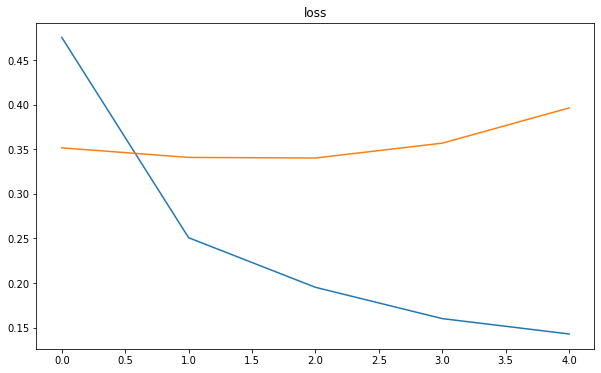

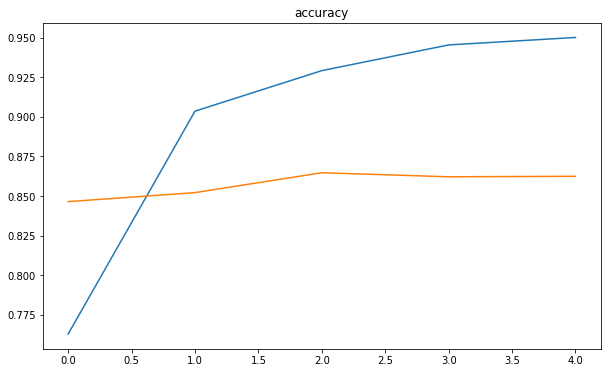

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)
scores = model9464.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model9464.metrics_names[1], scores[1]*100))

**Insert the discussion here**: [TO COMPLETE]

<h2><mark><b>Answer [Discussion]<h2><mark><b>

#####First of all, it should be mentioned that the 86% accuracy for sentiment analysis would be a good accuracy for this kind of problem. However, this opportunity still exist to improve the model's test accuracy and running time.
#####At first, the embedding size significantly impacts the number of parameters in the transformer's model. However, by increasing the number of attention or units in the feed-forward path, there is not too much difference compared to the impact of embedding size on the number of parameters. Generally speaking, results with smaller embedding size was better because of better accuracy and fewer parameters which takes less time to train the model. In a model with a bigger size of embedding vector, it is more probable to have more values near zeros which is unuseful, so the size of the embedding vector can be reduced until it does not have any negative impact on the performance of the model.
#####In addition to the embedding size, increasing the number of Attention heads will allow us to draw more information from different representations at different positions. The results show us that increasing the number of the head will improve the accuracy in most cases and do not add too many parameters to the model.
#####Another critical point is that it is always expected that the bigger model has better performance in neural networks. This trend is true in most cases, but it is essential to consider that the increasing number of hidden units in the fully connected feed-forward network in the encoder and decored part is exposed to overfitting. So it always can not be a good idea and should be chosen in a way to avoid overfitting in our case.
#####In conclusion, the performance of the transformers in sentiment analysis was better than the RNN with LASTM and GRU. In fact, the transformer has the same accuracy but in less time than LSTM and GRU.
